In [1]:
# 2018-2022년 전국 아파트 실거래 정보

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import openpyxl
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, normalize, RobustScaler, MinMaxScaler, FunctionTransformer
from scipy.stats import boxcox
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering
from haversine import haversine, Unit

In [4]:
# 건물코드, 건물이름, 주소 등 정보 불러와서 아파트만 남기기

df1 = pd.read_csv('/home/subin/다운로드/여피/0308 업무-20230310T030110Z-001/0308 업무/complex_20230308 (사본).csv', header=None)
df1.columns = ['old_addr_idx', 'complex_name', 'property_type','시도', '시군구',
               '읍면동','리','road_name','road_code','admin_dong_code','postal_code','jibun_main','jibun_sub','updated']
df1.drop(['road_name','road_code','admin_dong_code','postal_code','jibun_main','jibun_sub', 'updated'], axis=1, inplace=True)

df1['시군구'] = df1['시군구'].str.split().str[0]
df1 = df1[df1['property_type']!='officetel']
df1.drop(['property_type'], axis=1, inplace=True)
df1

,old_addr_idx,complex_name,시도,시군구,읍면동,리
0,1111010100_00001_00000_apartment,청운벽산빌리지,서울특별시,종로구,청운동,NaN
1,1111010100_00003_00000_apartment,인텔빌라B C동,서울특별시,종로구,청운동,NaN
2,1111010100_00003_00150_apartment,인텔빌라A동,서울특별시,종로구,청운동,NaN
3,1111010100_00004_00001_apartment,아델하우스,서울특별시,종로구,청운동,NaN
4,1111010100_00004_00003_apartment,GRACETUSCANII,서울특별시,종로구,청운동,NaN
...,...,...,...,...,...,...
320920,5013032022_00048_00003_apartment,표선제이파크빌,제주특별자치도,서귀포시,표선면,하천리
320921,5013032022_02167_00000_apartment,지오화이트빌리지,제주특별자치도,서귀포시,표선면,하천리
320922,5013032023_02008_00000_apartment,보네르펜션,제주특별자치도,서귀포시,표선면,성읍리
320923,5013032024_02521_00005_apartment,(2521-5),제주특별자치도,서귀포시,표선면,가시리


In [7]:
# 공시지가 데이터 불러오기

df2 = pd.read_csv('/home/subin/다운로드/여피/0308 업무-20230310T030110Z-001/0308 업무/property_20230308.csv', header=None)
df2.columns = ['pk','old_addr_idx','dong','ho','official_price','net_leasable_area','updated']

# 평수 데이터 생성 & 결측치 채우기

app_apt = df2.merge(df1, on='old_addr_idx')
pd.options.display.max_columns = None
app_apt['평수'] = app_apt['net_leasable_area'] / 3.3
app_apt.drop(['net_leasable_area'], axis=1, inplace=True)
app_apt.replace('\\N', np.nan, inplace=True)
app_apt['시군구'] = app_apt['시군구'].fillna('세종특별자치시')
app_apt

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수
0,00000001_0001_0001,1111010100_00004_00007_apartment,단일,101,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.978788
1,00000001_0001_0002,1111010100_00004_00007_apartment,단일,102,1076000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.396970
2,00000001_0001_0003,1111010100_00004_00007_apartment,단일,201,1140000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,62.996970
3,00000001_0001_0004,1111010100_00004_00007_apartment,단일,202,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,65.178788
4,00000001_0001_0005,1111010100_00004_00007_apartment,단일,301,1332000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,66.463636
...,...,...,...,...,...,...,...,...,...,...,...,...
14496524,20432545_0001_0012,2647010200_01288_00036_apartment,A,404,43100000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394
14496525,20432545_0001_0013,2647010200_01288_00036_apartment,A,502,43300000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.630303
14496526,20432545_0001_0014,2647010200_01288_00036_apartment,A,504,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394
14496527,20432545_0001_0015,2647010200_01288_00036_apartment,A,501,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394


In [8]:
sido_list = app_apt['시도'].unique().tolist()
sido_list

['서울특별시',
 '부산광역시',
 '인천광역시',
 '경기도',
 '강원도',
 '충청북도',
 '세종특별자치시',
 '대전광역시',
 '충청남도',
 '전라북도',
 '광주광역시',
 '전라남도',
 '대구광역시',
 '경상북도',
 '경상남도',
 '울산광역시',
 '제주특별자치도']

In [13]:
# 호수 정보를 층수로 변환하기 1단계 : 숫자 형식으로 되어있는 셀들을 '호int' 컬럼으로 분류

app_apt['호']=app_apt['ho'].astype(str)
app_apt['호int'] = app_apt['호'].apply(lambda x: int(x) if x.isnumeric() else 0)
app_apt['호str'] = app_apt['호'].apply(lambda x: np.nan if x.isnumeric() else 0 if x.isdigit() else x)
app_apt

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,호int,호str
0,00000001_0001_0001,1111010100_00004_00007_apartment,단일,101,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.978788,101,101,NaN
1,00000001_0001_0002,1111010100_00004_00007_apartment,단일,102,1076000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.396970,102,102,NaN
2,00000001_0001_0003,1111010100_00004_00007_apartment,단일,201,1140000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,62.996970,201,201,NaN
3,00000001_0001_0004,1111010100_00004_00007_apartment,단일,202,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,65.178788,202,202,NaN
4,00000001_0001_0005,1111010100_00004_00007_apartment,단일,301,1332000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,66.463636,301,301,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14496524,20432545_0001_0012,2647010200_01288_00036_apartment,A,404,43100000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,404,404,NaN
14496525,20432545_0001_0013,2647010200_01288_00036_apartment,A,502,43300000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.630303,502,502,NaN
14496526,20432545_0001_0014,2647010200_01288_00036_apartment,A,504,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,504,504,NaN
14496527,20432545_0001_0015,2647010200_01288_00036_apartment,A,501,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,501,501,NaN


In [14]:
# 호int 컬럼에서 맨 앞자리 숫자 따서 '층' 컬럼에 넣기

start = 100
step = 100
num_steps = 83
ranges1 = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]
labels1 = [r[2] for r in ranges1]
bins1 = [r[0] for r in ranges1] + [ranges1[-1][1]]

bins = bins1
labels = labels1

app_apt['층'] = pd.cut(app_apt['호int'], bins=bins, labels=labels, include_lowest=True, right=False)

In [15]:
# 호str 컬럼(숫자 외 형식 들어간 경우)에서 'n층' 형태로 되어있는 경우 추출

floorSplit = app_apt[app_apt['호str'].str.contains('층')==True]
floorSplit['호str'] = floorSplit['호str'].str.split('층').str[0]
floorSplit['호int'] = floorSplit['호str'].apply(lambda x: int(x) if x.isnumeric() else 0)

# n층에서 n 추출하여 '층' 컬럼에 삽입

start = 100
step = 100
num_steps = 16
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

floorSplit['층'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)

In [19]:
start1 = 1
step1 = 1
num_steps1 = 90
ranges2 = [(start1 + step1 * i, start1 + step1 * i + 0.1, i+1) for i in range(num_steps1)]
labels2 = [r[2] for r in ranges2]
bins2 = [r[0] for r in ranges2] + [ranges2[-1][1]]

# concatenate the two lists of bin edges and labels
bins = bins2
labels = labels2
# convert the '호int' column to a categorical column
floorSplit['층2'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)

<ipython-input-19-1196a492ffd3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['층2'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)


In [20]:
codes = floorSplit['층'].cat.codes
codes2 = floorSplit['층2'].cat.codes
floorSplit['codes'] = codes.reindex(floorSplit.index)
floorSplit['codes2'] = codes2.reindex(floorSplit.index)
floorSplit['codes'].replace(-1, np.nan, inplace=True)
floorSplit['codes2'].replace(-1, np.nan, inplace=True)
floorSplit['codes'] = floorSplit['codes'] + 1
floorSplit['codes2'] = floorSplit['codes2'] + 1
floorSplit['codes'] = floorSplit['codes'].fillna(floorSplit['codes2'])
floorSplit.drop(['층', '층2', 'codes2'], axis=1, inplace=True)

<ipython-input-20-493d9e1025b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['codes'] = codes.reindex(floorSplit.index)
<ipython-input-20-493d9e1025b8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['codes2'] = codes2.reindex(floorSplit.index)
<ipython-input-20-493d9e1025b8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [21]:
check = floorSplit[floorSplit['codes'].isnull()==True]

In [22]:
jiha = check[check['호str'].str.contains('지하')==True]
jiha['codes'] = -1
jiha = jiha[['pk', 'codes']]
check = check.merge(jiha, on=['pk'], how='left')
check = check.drop('codes_x', axis=1)
check = check.rename(columns={'codes_y':'codes'})

jisang = check[check['호str'].str.contains('지상')]
jisang['호str'] = jisang['호str'].str.split('지상').str[1]
jisang['codes'] = jisang['호str'].apply(lambda x: int(x) if x.isnumeric() else 0)

mask = (jisang['pk']=='11999085_0001_0001')
jisang.loc[mask, 'codes']=1
mask = (jisang['pk']=='12148950_0001_0002')
jisang.loc[mask, 'codes']=2
mask = (jisang['pk']=='12148950_0001_0004')
jisang.loc[mask, 'codes']=3
mask = (jisang['pk']=='12148950_0001_0005')
jisang.loc[mask, 'codes']=3
mask = (jisang['pk']=='12148950_0001_0006')
jisang.loc[mask, 'codes']=4

jisang = jisang[['pk', 'codes']]

check = check.merge(jisang, on=['pk'], how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

justJi = check[check['호str'].str.contains('지')&~(check['호str'].str.contains('지하'))&~(check['호str'].str.contains('지상'))]
justJi['codes'] = -1

justJi = justJi[['pk', 'codes']]

check = check.merge(justJi, on=['pk'], how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

<ipython-input-22-4e921100afe9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jiha['codes'] = -1
<ipython-input-22-4e921100afe9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang['호str'] = jisang['호str'].str.split('지상').str[1]
<ipython-input-22-4e921100afe9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [23]:
dong = check[(check['호str'].str.contains('동')==True) & (check['호str'].str.contains('지')!=True)]
dong['호str'] = dong['호str'].str.split('동').str[1]

mask = (dong['호str'].str.contains('3'))
dong.loc[mask, 'codes'] = 3
mask = (dong['호str'].str.contains('4'))
dong.loc[mask, 'codes'] = 4
mask = (dong['호str'].str.contains('일'))
dong.loc[mask, 'codes'] = 1
mask = (dong['호str'].str.contains('이'))
dong.loc[mask, 'codes'] = 2
mask = (dong['호str'].str.contains('삼'))
dong.loc[mask, 'codes'] = 3
mask = (dong['호str'].str.contains('사'))
dong.loc[mask, 'codes'] = 4
mask = (dong['호str'].str.contains('5'))
dong.loc[mask, 'codes'] = 5

mask = (dong['호str'].str.contains('1')) & (~dong['호str'].str.contains('2'))
dong.loc[mask, 'codes'] = 1
mask = (dong['호str'].str.contains('2')) & (~dong['호str'].str.contains('1'))
dong.loc[mask, 'codes'] = 2

mask = (dong['호str']=='10')
dong.loc[mask, 'codes'] = 10
mask = (dong['호str']=='11')
dong.loc[mask, 'codes'] = 11
mask = (dong['호str']=='12')
dong.loc[mask, 'codes'] = 12
mask = (dong['호str']=='13')
dong.loc[mask, 'codes'] = 13
mask = (dong['호str']=='14')
dong.loc[mask, 'codes'] = 14
mask = (dong['호str']=='15')
dong.loc[mask, 'codes'] = 15

mask = (dong['호str']=='2호1')
dong.loc[mask, 'codes'] = 1
mask = (dong['호str']=='1호2')
dong.loc[mask, 'codes'] = 2

dong = dong[['pk', 'codes']]

check = check.merge(dong, on='pk', how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

<ipython-input-23-9432fbcc790e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong['호str'] = dong['호str'].str.split('동').str[1]


In [24]:
rest = check[check['codes'].isnull()==True]

regex = r'\D+(\d+)$'
rest['codes'] = rest['호str'].str.extract(regex)

rest_of_rest = rest[rest['codes'].isnull()==True]

mask = (rest_of_rest['호str'].str.contains('일'))
rest_of_rest.loc[mask, 'codes'] = 1
mask = (rest_of_rest['호str'].str.contains('이'))
rest_of_rest.loc[mask, 'codes'] = 2
mask = (rest_of_rest['호str'].str.contains('사'))
rest_of_rest.loc[mask, 'codes'] = 4
mask = (rest_of_rest['호str'].str.contains('삼'))
rest_of_rest.loc[mask, 'codes'] = 3
mask = (rest_of_rest['호str'].str.contains('오'))
rest_of_rest.loc[mask, 'codes'] = 5
mask = (rest_of_rest['호str'].str.contains('육'))
rest_of_rest.loc[mask, 'codes'] = 6
mask = (rest_of_rest['호str'].str.contains('칠'))
rest_of_rest.loc[mask, 'codes'] = 7

rest_of_rest_bok = rest_of_rest[rest_of_rest['codes'].isnull()==True]
rest_of_rest_bok = rest_of_rest[rest_of_rest['호str'].str.contains('복')]
rest_of_rest_bok['호str']= rest_of_rest_bok['호str'].str.split('복').str[0]

rest_of_rest_bok['numeric'] = rest_of_rest_bok['호str'].str.extract('(\d+)')
rest_of_rest_bok['numeric'] = rest_of_rest_bok['numeric'].fillna(0)
rest_of_rest_bok['numeric'] = rest_of_rest_bok['numeric'].astype(int)

start = 100
step = 100
num_steps = 16
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

rest_of_rest_bok['층'] = pd.cut(rest_of_rest_bok['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)



<ipython-input-24-3e2152d64c0e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest['codes'] = rest['호str'].str.extract(regex)
<ipython-input-24-3e2152d64c0e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_rest_bok['호str']= rest_of_rest_bok['호str'].str.split('복').str[0]
<ipython-input-24-3e2152d64c0e>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [25]:
codes3 = rest_of_rest_bok['층'].cat.codes
rest_of_rest_bok['codes3'] = codes3.reindex(rest_of_rest_bok.index)
rest_of_rest_bok['codes3'].replace(-1, np.nan, inplace=True)
rest_of_rest_bok['codes3'] = rest_of_rest_bok['codes3'] + 1
rest_of_rest_bok.drop(['codes', 'numeric', '층'], axis=1, inplace=True)
rest_of_rest_bok = rest_of_rest_bok.rename(columns={'codes3':'codes'})
rest_of_rest_bok = rest_of_rest_bok[['pk', 'codes']]

rest_of_rest = rest_of_rest.merge(rest_of_rest_bok, on='pk', how='left')
rest_of_rest['codes_x'] = rest_of_rest['codes_x'].fillna(rest_of_rest['codes_y'])
rest_of_rest = rest_of_rest.rename(columns={'codes_x':'codes'})
rest_of_rest.drop('codes_y', axis=1, inplace=True)

mask = (rest_of_rest['codes']==0)
rest_of_rest.loc[mask, 'codes'] = 3

<ipython-input-25-1b9d5dade8fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_rest_bok['codes3'] = codes3.reindex(rest_of_rest_bok.index)
<ipython-input-25-1b9d5dade8fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_rest_bok['codes3'].replace(-1, np.nan, inplace=True)
<ipython-input-25-1b9d5dade8fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [26]:
rest_of_rest_ = rest_of_rest[rest_of_rest['codes'].isnull()==True]

mask = (rest_of_rest_['ho'].str.contains('별층'))
rest_of_rest_.loc[mask, 'codes'] = -1
mask = (rest_of_rest_['ho'].str.contains('비층'))
rest_of_rest_.loc[mask, 'codes'] = -1
mask = (rest_of_rest_['ho'].str.contains('B'))
rest_of_rest_.loc[mask, 'codes'] = -1
mask = (rest_of_rest_['ho'].str.contains('401'))
rest_of_rest_.loc[mask, 'codes'] = 4
mask = (rest_of_rest_['ho'].str.contains('402'))
rest_of_rest_.loc[mask, 'codes'] = 4
mask = (rest_of_rest_['ho'].str.contains('201'))
rest_of_rest_.loc[mask, 'codes'] = 2
mask = (rest_of_rest_['ho'].str.contains('202'))
rest_of_rest_.loc[mask, 'codes'] = 2

mask = (rest_of_rest_['pk']=='12085035_0001_0004')
rest_of_rest_.loc[mask, 'codes'] = 4

rest_of_rest_ = rest_of_rest_[['pk', 'codes']]

rest_of_rest = rest_of_rest.merge(rest_of_rest_, on='pk', how='left')
rest_of_rest['codes_x'] = rest_of_rest['codes_x'].fillna(rest_of_rest['codes_y'])
rest_of_rest = rest_of_rest.rename(columns={'codes_x':'codes'})
rest_of_rest.drop('codes_y', axis=1, inplace=True)

rest_of_rest = rest_of_rest[['pk', 'codes']]
rest = rest.merge(rest_of_rest, on='pk', how='left')
rest['codes_x'] = rest['codes_x'].fillna(rest['codes_y'])
rest = rest.rename(columns={'codes_x':'codes'})
rest.drop('codes_y', axis=1, inplace=True)

rest = rest[['pk', 'codes']]
check = check.merge(rest, on='pk', how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

check = check[['pk', 'codes']]
floorSplit = floorSplit.merge(check, on='pk', how='left')
floorSplit['codes_x'] = floorSplit['codes_x'].fillna(floorSplit['codes_y'])
floorSplit = floorSplit.rename(columns={'codes_x':'codes'})
floorSplit.drop('codes_y', axis=1, inplace=True)

mask = (floorSplit['pk']=='12030365_0001_0005')
floorSplit.loc[mask, 'codes'] = 3
mask = (floorSplit['pk']=='12035834_0001_0003')
floorSplit.loc[mask, 'codes'] = 3

In [27]:
codes4 = app_apt['층'].cat.codes
app_apt['codes'] = codes4.reindex(app_apt.index)
app_apt['codes'] = app_apt['codes'] + 1
app_apt['codes'].replace(0, np.nan, inplace=True)

floorSplit = floorSplit[['pk', 'codes']]
app_apt = app_apt.merge(floorSplit, on='pk', how='left')
app_apt['codes_x'] = app_apt['codes_x'].fillna(app_apt['codes_y'])
app_apt = app_apt.rename(columns={'codes_x':'codes'})
app_apt.drop('codes_y', axis=1, inplace=True)

In [28]:
last = app_apt[app_apt['codes'].isnull()==True]
last.drop(['호int', '호str', '층'], axis=1, inplace=True)

<ipython-input-28-a88709004904>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last.drop(['호int', '호str', '층'], axis=1, inplace=True)


In [29]:
last['codes'].info()

<class 'pandas.core.series.Series'>
Int64Index: 230837 entries, 6 to 14495298
Series name: codes
Non-Null Count  Dtype 
--------------  ----- 
0 non-null      object
dtypes: object(1)
memory usage: 3.5+ MB


In [30]:
jiha2 = last[last['호'].str.contains('지하')==True]
jiha2['codes'] = -1
jiha2 = jiha2[['pk', 'codes']]
last = last.merge(jiha2, on=['pk'], how='left')
last = last.drop('codes_x', axis=1)
last = last.rename(columns={'codes_y':'codes'})

<ipython-input-30-c4a92d2f4a90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jiha2['codes'] = -1


In [31]:
jisang2 = last[last['호'].str.contains('지상')]
jisang2['호'] = jisang2['호'].str.split('지상').str[1]

<ipython-input-31-25076aa31f93>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang2['호'] = jisang2['호'].str.split('지상').str[1]


In [32]:
jisang2['numeric'] = jisang2['호'].str.extract('(\d+)')
jisang2['numeric'] = jisang2['numeric'].fillna(0)
jisang2['numeric'] = jisang2['numeric'].astype(int)

start = 100
step = 100
num_steps = 18
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

jisang2['층'] = pd.cut(jisang2['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)

start1 = 1
step1 = 1
num_steps1 = 90
ranges2 = [(start1 + step1 * i, start1 + step1 * i + 0.1, i+1) for i in range(num_steps1)]
labels2 = [r[2] for r in ranges2]
bins2 = [r[0] for r in ranges2] + [ranges2[-1][1]]

# concatenate the two lists of bin edges and labels
bins = bins2
labels = labels2
# convert the 'numeric' column to a categorical column
jisang2['층2'] = pd.cut(jisang2['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)

codes = jisang2['층'].cat.codes
codes2 = jisang2['층2'].cat.codes
jisang2['codes'] = codes.reindex(jisang2.index)
jisang2['codes2'] = codes2.reindex(jisang2.index)
jisang2['codes'].replace(-1, np.nan, inplace=True)
jisang2['codes2'].replace(-1, np.nan, inplace=True)
jisang2['codes'] = jisang2['codes'] + 1
jisang2['codes2'] = jisang2['codes2'] + 1
jisang2['codes'] = jisang2['codes'].fillna(jisang2['codes2'])
jisang2.drop(['층', '층2', 'codes2', 'numeric'], axis=1, inplace=True)

mask = (jisang2['pk']=='20031264_0001_0001')
jisang2.loc[mask, 'codes'] = 1

<ipython-input-32-4e5c74641632>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang2['numeric'] = jisang2['호'].str.extract('(\d+)')
<ipython-input-32-4e5c74641632>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang2['numeric'] = jisang2['numeric'].fillna(0)
<ipython-input-32-4e5c74641632>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [33]:
last

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,codes
0,00000001_0001_0007,1111010100_00004_00007_apartment,단일,B02,390000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,27.490909,B02,NaN
1,00000001_0001_0008,1111010100_00004_00007_apartment,단일,B01,524000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,35.990909,B01,NaN
2,00000002_0001_0001,1111010100_00003_00000_apartment,비,1,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.927273,1,NaN
3,00000002_0001_0002,1111010100_00003_00000_apartment,비,10,1391000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.745455,10,NaN
4,00000002_0001_0003,1111010100_00003_00000_apartment,비,2,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.800000,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230832,20430554_0002_0019,4146125321_00531_00005_apartment,102,B03,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B03,NaN
230833,20430554_0002_0020,4146125321_00531_00005_apartment,102,B04,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B04,NaN
230834,20431047_0001_0009,4161025322_00277_00007_apartment,101,B02,216000000,2021-10-01,T.S크라이시Ⅲ,경기도,광주시,초월읍,쌍동리,25.374242,B02,NaN
230835,20431216_0001_0001,4122025042_00088_00000_apartment,A,A,573000000,2021-06-01,WoodenBreeze,경기도,평택시,팽성읍,동창리,82.887879,A,NaN


In [34]:
jisang2 = jisang2[['pk', 'codes']]
last = last.merge(jisang2, on='pk', how='left')
last['codes_x'] = last['codes_x'].fillna(last['codes_y'])
last = last.rename(columns={'codes_x':'codes'})
last.drop('codes_y', axis=1, inplace=True)

In [35]:
last['codes'].info()

<class 'pandas.core.series.Series'>
Int64Index: 230837 entries, 0 to 230836
Series name: codes
Non-Null Count  Dtype  
--------------  -----  
9511 non-null   float64
dtypes: float64(1)
memory usage: 3.5 MB


In [36]:
last = last[['pk', 'codes']]
last = last.dropna(subset='codes')
app_apt = app_apt.merge(last, on='pk', how='left')
app_apt['codes_x'] = app_apt['codes_x'].fillna(app_apt['codes_y'])
app_apt = app_apt.rename(columns={'codes_x':'codes'})
app_apt.drop('codes_y', axis=1, inplace=True)

In [37]:
app_apt_match = app_apt[['old_addr_idx', 'official_price', '시도', '시군구', '읍면동', '리', '평수', 'codes']]

In [38]:
###########################################                                         ###################################
##############################################    공시지가 층수 작업 미완료 !!!    #############################################
###########################################       공시지가 층수 작업 미완료 !!!      #######################################
#########################################                                           ###############################################

pd.set_option('display.max_rows', 10)

In [39]:
last2 = app_apt[app_apt['codes'].isnull()==True]

In [40]:
last2['numeric'] = last2['호'].str.extract('(\d+)')
last2['numeric'] = last2['numeric'].fillna(0)
last2['numeric'] = last2['numeric'].astype(int)

start = 100
step = 100
num_steps = 50
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

last2['층'] = pd.cut(last2['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)

<ipython-input-40-7494bad5c2f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['numeric'] = last2['호'].str.extract('(\d+)')
<ipython-input-40-7494bad5c2f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['numeric'] = last2['numeric'].fillna(0)
<ipython-input-40-7494bad5c2f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [41]:
mask = (last2['numeric']==0)
last2.loc[mask, 'numeric'] = 1

In [42]:
mask = (last2['호'].str.contains('B0'))
last2.loc[mask, 'numeric'] = -1

In [43]:
codes5 = last2['층'].cat.codes
last2['codes2'] = codes.reindex(last2.index)
last2['codes2'].replace(-1, np.nan, inplace=True)
last2['codes2'] = last2['codes2'] + 1
last2['codes'] = last2['codes'].fillna(last2['codes2'])
last2['codes'] = last2['codes'].fillna(last2['numeric'])
last2.drop(['층','codes2', 'numeric'], axis=1, inplace=True)

<ipython-input-43-924028124f2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['codes2'] = codes.reindex(last2.index)
<ipython-input-43-924028124f2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['codes2'].replace(-1, np.nan, inplace=True)
<ipython-input-43-924028124f2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [44]:
last2

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,호int,호str,codes
6,00000001_0001_0007,1111010100_00004_00007_apartment,단일,B02,390000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,27.490909,B02,0,B02,-1.0
7,00000001_0001_0008,1111010100_00004_00007_apartment,단일,B01,524000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,35.990909,B01,0,B01,-1.0
8,00000002_0001_0001,1111010100_00003_00000_apartment,비,1,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.927273,1,1,NaN,1.0
9,00000002_0001_0002,1111010100_00003_00000_apartment,비,10,1391000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.745455,10,10,NaN,10.0
10,00000002_0001_0003,1111010100_00003_00000_apartment,비,2,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.800000,2,2,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14482716,20430554_0002_0019,4146125321_00531_00005_apartment,102,B03,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B03,0,B03,-1.0
14482717,20430554_0002_0020,4146125321_00531_00005_apartment,102,B04,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B04,0,B04,-1.0
14493054,20431047_0001_0009,4161025322_00277_00007_apartment,101,B02,216000000,2021-10-01,T.S크라이시Ⅲ,경기도,광주시,초월읍,쌍동리,25.374242,B02,0,B02,-1.0
14495297,20431216_0001_0001,4122025042_00088_00000_apartment,A,A,573000000,2021-06-01,WoodenBreeze,경기도,평택시,팽성읍,동창리,82.887879,A,0,A,1.0


In [45]:
last2 = last2[['pk', 'codes']]
app_apt = app_apt.merge(last2, on='pk', how='left')
app_apt['codes_x'] = app_apt['codes_x'].fillna(app_apt['codes_y'])
app_apt = app_apt.rename(columns={'codes_x':'codes'})
app_apt.drop('codes_y', axis=1, inplace=True)

In [46]:
app_apt

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,호int,호str,층,codes
0,00000001_0001_0001,1111010100_00004_00007_apartment,단일,101,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.978788,101,101,NaN,1,1.0
1,00000001_0001_0002,1111010100_00004_00007_apartment,단일,102,1076000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.396970,102,102,NaN,1,1.0
2,00000001_0001_0003,1111010100_00004_00007_apartment,단일,201,1140000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,62.996970,201,201,NaN,2,2.0
3,00000001_0001_0004,1111010100_00004_00007_apartment,단일,202,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,65.178788,202,202,NaN,2,2.0
4,00000001_0001_0005,1111010100_00004_00007_apartment,단일,301,1332000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,66.463636,301,301,NaN,3,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14496524,20432545_0001_0012,2647010200_01288_00036_apartment,A,404,43100000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,404,404,NaN,4,4.0
14496525,20432545_0001_0013,2647010200_01288_00036_apartment,A,502,43300000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.630303,502,502,NaN,5,5.0
14496526,20432545_0001_0014,2647010200_01288_00036_apartment,A,504,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,504,504,NaN,5,5.0
14496527,20432545_0001_0015,2647010200_01288_00036_apartment,A,501,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,501,501,NaN,5,5.0


In [47]:
app_apt_match = app_apt[['old_addr_idx', 'official_price', '시도', '시군구', '읍면동', '리', '평수', 'codes']]
app_apt_match = app_apt_match.rename(columns={'codes':'층수', 'official_price':'공시지가'})
app_apt_match = app_apt_match.drop_duplicates()

In [48]:
app_apt_match

,old_addr_idx,공시지가,시도,시군구,읍면동,리,평수,층수
0,1111010100_00004_00007_apartment,1249000000,서울특별시,종로구,청운동,NaN,63.978788,1.0
1,1111010100_00004_00007_apartment,1076000000,서울특별시,종로구,청운동,NaN,63.396970,1.0
2,1111010100_00004_00007_apartment,1140000000,서울특별시,종로구,청운동,NaN,62.996970,2.0
3,1111010100_00004_00007_apartment,1249000000,서울특별시,종로구,청운동,NaN,65.178788,2.0
4,1111010100_00004_00007_apartment,1332000000,서울특별시,종로구,청운동,NaN,66.463636,3.0
...,...,...,...,...,...,...,...,...
14496518,2647010200_01288_00036_apartment,43100000,부산광역시,연제구,연산동,NaN,5.539394,3.0
14496521,2647010200_01288_00036_apartment,43900000,부산광역시,연제구,연산동,NaN,5.630303,4.0
14496523,2647010200_01288_00036_apartment,43100000,부산광역시,연제구,연산동,NaN,5.539394,4.0
14496525,2647010200_01288_00036_apartment,43300000,부산광역시,연제구,연산동,NaN,5.630303,5.0


In [49]:
app_main = app_apt_match[(app_apt_match['시도']=='서울특별시')|(app_apt_match['시도']=='경기도')|(app_apt_match['시도']=='인천광역시')]

In [50]:
app_main

,old_addr_idx,공시지가,시도,시군구,읍면동,리,평수,층수
0,1111010100_00004_00007_apartment,1249000000,서울특별시,종로구,청운동,NaN,63.978788,1.0
1,1111010100_00004_00007_apartment,1076000000,서울특별시,종로구,청운동,NaN,63.396970,1.0
2,1111010100_00004_00007_apartment,1140000000,서울특별시,종로구,청운동,NaN,62.996970,2.0
3,1111010100_00004_00007_apartment,1249000000,서울특별시,종로구,청운동,NaN,65.178788,2.0
4,1111010100_00004_00007_apartment,1332000000,서울특별시,종로구,청운동,NaN,66.463636,3.0
...,...,...,...,...,...,...,...,...
14496479,2817710500_00295_00000_apartment,173000000,인천광역시,미추홀구,주안동,NaN,18.119364,15.0
14496485,2817710500_00295_00000_apartment,173000000,인천광역시,미추홀구,주안동,NaN,18.119364,16.0
14496491,2817710500_00295_00000_apartment,173000000,인천광역시,미추홀구,주안동,NaN,18.119364,17.0
14496497,2817710500_00295_00000_apartment,173000000,인천광역시,미추홀구,주안동,NaN,18.119364,18.0


In [51]:
areaCode = pd.read_excel('/home/subin/다운로드/행정_법정동 중심좌표_동별.xlsx')
areaCode = areaCode[areaCode['코드종류']=='B']
areaCode.drop(['코드', '코드종류'], axis=1, inplace=True)
areaCode['시군구'] = areaCode['시군구'].str.split().str[0]

In [52]:
areaCodeMain = areaCode[(areaCode['시도']=='서울특별시')|(areaCode['시도']=='경기도')|(areaCode['시도']=='인천광역시')]

In [53]:
app_main = app_main.merge(areaCodeMain, on=['시도', '시군구', '읍면동', '리'], how='left')

In [54]:
fill = app_main[app_main['위도'].isnull()==True]
sidoList = fill['시도'].unique().tolist()

In [55]:
sidoList[1]

'인천광역시'

In [56]:
k=0
code = areaCodeMain[areaCodeMain['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()
code['읍면동'] = np.nan
app_main = code.set_index(['시도', '시군구','읍면동']).combine_first(app_main.set_index(['시도', '시군구', '읍면동'])).reset_index()

<ipython-input-56-19130c043e09>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  code = areaCodeMain[areaCodeMain['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()


In [57]:
k=1
code = areaCodeMain[areaCodeMain['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()
code['읍면동'] = np.nan
app_main = code.set_index(['시도', '시군구','읍면동']).combine_first(app_main.set_index(['시도', '시군구', '읍면동'])).reset_index()

<ipython-input-57-d73b90e5788b>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  code = areaCodeMain[areaCodeMain['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()


In [58]:
k=2

mask = (app_main['읍면동']=='퇴계원읍')
app_main.loc[mask, '읍면동'] = '퇴계원면'
#app_main.loc[mask, '위도'] = areaCode.iloc[1086,4]
#app_main.loc[mask, '경도'] = areaCode.iloc[1086,5]

mask = (app_main['읍면동']=='남사읍') & (app_main['시군구']=='용인시')
app_main.loc[mask, '읍면동'] = '남사면'

mask = (app_main['읍면동']=='세종대왕면')
app_main.loc[mask, '읍면동'] = '능서면'

mask = (app_main['읍면동']=='배곧동')
app_main.loc[mask, '위도'] = (areaCode.iloc[1086,4] + areaCode.iloc[2474,4])/2
app_main.loc[mask, '경도'] = (areaCode.iloc[1086,5] + areaCode.iloc[2474,5])/2

mask = (app_main['읍면동']=='고덕동')
app_main.loc[mask, '위도'] = (areaCode.iloc[2231,4] + areaCode.iloc[2198,4])/2
app_main.loc[mask, '경도'] = (areaCode.iloc[2231,5] + areaCode.iloc[2198,5])/2

code = areaCode[areaCode['시도']==sidoList[k]]
#areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구', '읍면동']).mean().reset_index()
mean_by_dong = code.groupby(['시도', '시군구', '읍면동']).mean().reset_index()
code = pd.concat([code, mean_by_dong], ignore_index=True)
code = code.sort_values(['시도', '시군구', '읍면동'])

mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()
code = pd.concat([code, mean_by_sigungu], ignore_index=True)
code = code.sort_values(['시도', '시군구'])

app_main = code.set_index(['시도', '시군구', '읍면동', '리']).combine_first(app_main.set_index(['시도', '시군구', '읍면동', '리'])).reset_index()
app_main = app_main.dropna(subset='공시지가')

<ipython-input-58-712ea363861f>:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_dong = code.groupby(['시도', '시군구', '읍면동']).mean().reset_index()
<ipython-input-58-712ea363861f>:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()


In [59]:
app_main= app_main.reset_index()

In [60]:
app_main

,index,시도,시군구,읍면동,리,old_addr_idx,경도,공시지가,위도,층수,평수
0,1,경기도,가평군,가평읍,경반리,4182025027_00240_00001_apartment,127.489038,53400000.0,37.833291,1.0,23.309091
1,2,경기도,가평군,가평읍,경반리,4182025027_00240_00001_apartment,127.489038,56400000.0,37.833291,2.0,23.309091
2,3,경기도,가평군,가평읍,경반리,4182025027_00240_00001_apartment,127.489038,56400000.0,37.833291,3.0,23.309091
3,4,경기도,가평군,가평읍,경반리,4182025027_00240_00001_apartment,127.489038,54600000.0,37.833291,4.0,23.309091
4,5,경기도,가평군,가평읍,경반리,4182025027_00240_00001_apartment,127.489038,42000000.0,37.833291,1.0,18.357576
...,...,...,...,...,...,...,...,...,...,...,...
3358714,3359779,인천광역시,중구,NaN,NaN,2811014800_00453_00066_apartment,126.600268,134000000.0,37.470681,1.0,15.739394
3358715,3359780,인천광역시,중구,NaN,NaN,2811014800_00453_00066_apartment,126.600268,134000000.0,37.470681,2.0,15.739394
3358716,3359781,인천광역시,중구,NaN,NaN,2811014800_00453_00066_apartment,126.600268,134000000.0,37.470681,3.0,15.739394
3358717,3359782,인천광역시,중구,NaN,NaN,2811014800_00453_00066_apartment,126.600268,134000000.0,37.470681,4.0,15.739394


In [61]:
main_name = app_main[['old_addr_idx', '위도', '경도']]
main_name = main_name.drop_duplicates()
main_name['위도+경도'] = main_name['위도'].astype(str) + main_name['경도'].astype(str)

In [62]:
mainArea = app_main[['위도', '경도']]
mainArea = mainArea.drop_duplicates()
mainArea['위도+경도'] = mainArea['위도'].astype(str) + mainArea['경도'].astype(str)

In [63]:
school = pd.read_excel('/home/subin/다운로드/전국초중등학교위치표준데이터-20230404.xls')
school.rename(columns=school.iloc[0], inplace=True)
school = school.drop(0)

school['시도']=school['시도교육청명'].str.split('교육청').str[0]
school.drop(['시도교육청명', '제공기관명', '생성일자', '변경일자', '교육지원청명', '데이터기준일자','소재지지번주소', '소재지도로명주소', '설립일자',
             '학교ID', '제공기관코드', '시도교육청코드', '교육지원청코드', '운영상태'], axis=1, inplace=True)
school['학교급구분'] = school['학교급구분'].str.split('학교').str[0]

school['위도'] = school['위도'].astype(float).round(6)
school['경도'] = school['경도'].astype(float).round(6)

In [64]:
school_main = school[(school['시도']=='서울특별시')|(school['시도']=='경기도')|(school['시도']=='인천광역시')]
school_main

,학교명,학교급구분,설립형태,본교분교구분,위도,경도,시도
7,하안중학교,중,공립,본교,37.467386,126.880772,경기도
8,현산중학교,중,공립,본교,37.691246,126.774003,경기도
9,은광여자고등학교,고등,사립,본교,37.488379,127.035232,서울특별시
12,숭덕여자고등학교,고등,사립,본교,37.464282,126.733917,인천광역시
13,산마을고등학교,고등,사립,본교,37.686363,126.425565,인천광역시
...,...,...,...,...,...,...,...
11975,서울문영여자고등학교,고등,사립,본교,37.472905,126.950918,서울특별시
11976,서울갈산초등학교,초등,공립,본교,37.512372,126.870230,서울특별시
11977,서울태랑초등학교,초등,공립,본교,37.628783,127.088992,서울특별시
11978,서울한천초등학교,초등,공립,본교,37.620709,127.069244,서울특별시


In [65]:
school_ele = school_main[school_main['학교급구분']=='초등']
school_mid = school_main[school_main['학교급구분']=='중']
school_high = school_main[school_main['학교급구분']=='고등']

In [66]:
school_mainArea= school_main.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_eleArea = school_ele.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_midArea = school_mid.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_highArea = school_high.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)

In [67]:
subway = pd.read_csv('/home/subin/다운로드/서울시 역사마스터 정보.csv',encoding='cp949')
subway_name = subway.drop(['역사_ID', '호선'], axis=1)
subway_name['환승역'] = 0  # set all values in the '환승역' column to 0 first
duplicates = subway_name['역사명'].duplicated()  # identify duplicated values in the '역사명' column
subway_name.loc[duplicates, '환승역'] = 1  # set the '환승역' column to 1 only for duplicated rows
subway_name = subway_name[subway_name['환승역'] != 1]
subway_name = subway_name.rename(columns={'위도': '경도', '경도': '위도'})

In [68]:
from scipy.spatial.distance import cdist
housing_coords = mainArea[['위도', '경도']].values
subway_coords = subway_name[['위도', '경도']].values
distances_matrix = cdist(housing_coords, subway_coords, metric=haversine)
distances_df = pd.DataFrame(distances_matrix, columns=subway_name['역사명'], index=mainArea['위도+경도'])
distances_df = distances_df.reset_index().melt(id_vars='위도+경도', var_name='subway_id', value_name='distance')

In [69]:
distances_df['subway_id'] = distances_df['subway_id'].replace('총신대입구', '이수')

In [70]:
dis_df_162km = distances_df[distances_df['distance']<162]
main_subway_162km = main_name.merge(dis_df_162km, on='위도+경도')
main_subway_162km.drop(['위도', '경도', '위도+경도'], axis=1, inplace=True)

In [71]:
main_subway_1km =main_subway_162km[main_subway_162km['distance']<=1]
main_subway = pd.merge(main_name, main_subway_1km, how='left', on='old_addr_idx')
value_counts = main_subway[main_subway['distance']<=1]['old_addr_idx'].value_counts()
app_main['1km내sub수'] = app_main['old_addr_idx'].map(value_counts)
app_main['1km내sub수'] = app_main['1km내sub수'].fillna(0)

In [72]:
closest_subway_dis =main_subway_162km.groupby('old_addr_idx').min().drop('subway_id', axis=1).reset_index()
app_main = app_main.merge(closest_subway_dis, how='left', on='old_addr_idx')
app_main = app_main.rename(columns={'distance': 'closest_sub'})

In [73]:
housing_coords = mainArea[['위도', '경도']].values
school_coords = school_main[['위도', '경도']].values
distances_matrix2 = cdist(housing_coords, school_coords, metric=haversine)
distances_df2 = pd.DataFrame(distances_matrix2, columns=school_main['학교명'], index=mainArea['위도+경도'])
distances_df2 = distances_df2.reset_index().melt(id_vars='위도+경도', var_name='school_id', value_name='distance')

In [74]:
dis_df2_25km = distances_df2[distances_df2['distance']<25]
dis_df2_25km['school_id'] = dis_df2_25km['school_id'].replace('인천과학예술영재학교', '인천과학예술영재고등학교')
dis_df2_25km['school_id'] = dis_df2_25km['school_id'].replace('동성고등공민학교', '동성공민고등학교')

<ipython-input-74-eafbafa148a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_df2_25km['school_id'] = dis_df2_25km['school_id'].replace('인천과학예술영재학교', '인천과학예술영재고등학교')
<ipython-input-74-eafbafa148a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_df2_25km['school_id'] = dis_df2_25km['school_id'].replace('동성고등공민학교', '동성공민고등학교')


In [75]:
dis_ele_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('초등학교')]
dis_mid_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('중학교')]
dis_high_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('고등학교')]

In [76]:
main_high_25km = main_name.merge(dis_high_25km.drop('school_id', axis=1), on='위도+경도')
closest_high_dis = main_high_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [77]:
app_main = app_main.merge(closest_high_dis, how='left', on='old_addr_idx')
app_main = app_main.rename(columns={'distance': 'closest_high'})

In [78]:
main_mid_25km = main_name.merge(dis_mid_25km.drop('school_id', axis=1), on='위도+경도')
closest_mid_dis = main_mid_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [79]:
app_main = app_main.merge(closest_mid_dis, how='left', on='old_addr_idx')
app_main = app_main.rename(columns={'distance': 'closest_mid'})

In [80]:
main_ele_25km = main_name.merge(dis_ele_25km.drop('school_id', axis=1), on='위도+경도')
closest_ele_dis = main_ele_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [81]:
app_main = app_main.merge(closest_ele_dis, how='left', on='old_addr_idx')
app_main = app_main.rename(columns={'distance': 'closest_ele'})

In [82]:
dis_school_3km = dis_df2_25km[dis_df2_25km['distance']<3]

In [83]:
main_school_3km = main_name.merge(dis_school_3km.drop('school_id', axis=1), on='위도+경도')

In [84]:
main_school_1km =main_school_3km[main_school_3km['distance']<=1]
main_school = pd.merge(main_name, main_school_1km, how='left', on='old_addr_idx')
value_counts2 = main_school[main_school['distance']<=1]['old_addr_idx'].value_counts()
app_main['school_1km'] = app_main['old_addr_idx'].map(value_counts2)
app_main['school_1km'] = app_main['school_1km'].fillna(0)

In [85]:
app_main['평수'] = app_main['평수'].astype(float).round(0)
app_main['층수'] = app_main['층수'].astype(int)

In [86]:
app_main

,index,시도,시군구,읍면동,리,old_addr_idx,경도,공시지가,위도,층수,평수,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km
0,1,경기도,가평군,가평읍,경반리,4182025027_00240_00001_apartment,127.489038,53400000.0,37.833291,1,23.0,0.0,2.825284,2.691795,1.951456,1.626459,0.0
1,2,경기도,가평군,가평읍,경반리,4182025027_00240_00001_apartment,127.489038,56400000.0,37.833291,2,23.0,0.0,2.825284,2.691795,1.951456,1.626459,0.0
2,3,경기도,가평군,가평읍,경반리,4182025027_00240_00001_apartment,127.489038,56400000.0,37.833291,3,23.0,0.0,2.825284,2.691795,1.951456,1.626459,0.0
3,4,경기도,가평군,가평읍,경반리,4182025027_00240_00001_apartment,127.489038,54600000.0,37.833291,4,23.0,0.0,2.825284,2.691795,1.951456,1.626459,0.0
4,5,경기도,가평군,가평읍,경반리,4182025027_00240_00001_apartment,127.489038,42000000.0,37.833291,1,18.0,0.0,2.825284,2.691795,1.951456,1.626459,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3358714,3359779,인천광역시,중구,NaN,NaN,2811014800_00453_00066_apartment,126.600268,134000000.0,37.470681,1,16.0,0.0,1.634313,0.258733,2.164478,1.998017,1.0
3358715,3359780,인천광역시,중구,NaN,NaN,2811014800_00453_00066_apartment,126.600268,134000000.0,37.470681,2,16.0,0.0,1.634313,0.258733,2.164478,1.998017,1.0
3358716,3359781,인천광역시,중구,NaN,NaN,2811014800_00453_00066_apartment,126.600268,134000000.0,37.470681,3,16.0,0.0,1.634313,0.258733,2.164478,1.998017,1.0
3358717,3359782,인천광역시,중구,NaN,NaN,2811014800_00453_00066_apartment,126.600268,134000000.0,37.470681,4,16.0,0.0,1.634313,0.258733,2.164478,1.998017,1.0


In [87]:
###########################################      실거래가         ############################################################

In [88]:
df3 = pd.read_csv('/home/subin/다운로드/여피/0315 업무/trade_history_2018-2023_edit.csv', header=None)
df3.columns = ['old_addr_idx', '거래날짜', '거래가격', '면적', '층수', '모름', '거래방식', '모름2', '모름3', '시군구', '주소', '읍면동', 'complex_name', '모름4', '모름5', 'property_type']
df3 = df3.drop_duplicates() 
df3['평수'] = df3['면적']/3.3
df3.fillna("NONE", inplace=True)
df3 = df3[~df3['property_type'].str.contains('officetel')]
df3 = df3[['old_addr_idx', '거래가격', '평수', '층수']]
df3

<ipython-input-88-b5dea2fc0aa1>:1: DtypeWarning: Columns (5,6,8,9,10,11,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('/home/subin/다운로드/여피/0315 업무/trade_history_2018-2023_edit.csv', header=None)


,old_addr_idx,거래가격,평수,층수
0,3023010200_00034_00000_apartment,99000000,17.890909,2
1,3023010200_00027_00007_apartment,70000000,17.048485,5
2,3023010200_00027_00007_apartment,66000000,17.048485,1
3,3023010200_00027_00007_apartment,77000000,17.048485,3
4,3023010200_00027_00007_apartment,70000000,17.048485,5
...,...,...,...,...
2203363,5011010400_01034_00001_apartment,280000000,25.436970,5
2203364,5011010400_00777_00000_apartment,580000000,12.027273,4
2203365,5013010400_02161_00000_apartment,317000000,25.704212,2
2203366,5013010500_00147_00000_apartment,214000000,12.027273,1


In [89]:
df3 = df3.drop_duplicates()
df3['평수'] = df3['평수'].astype(float).round(0)

<ipython-input-89-695803c55b6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['평수'] = df3['평수'].astype(float).round(0)


In [90]:
df3

,old_addr_idx,거래가격,평수,층수
0,3023010200_00034_00000_apartment,99000000,18.0,2
1,3023010200_00027_00007_apartment,70000000,17.0,5
2,3023010200_00027_00007_apartment,66000000,17.0,1
3,3023010200_00027_00007_apartment,77000000,17.0,3
5,3023010200_00027_00007_apartment,97500000,17.0,5
...,...,...,...,...
2203363,5011010400_01034_00001_apartment,280000000,25.0,5
2203364,5011010400_00777_00000_apartment,580000000,12.0,4
2203365,5013010400_02161_00000_apartment,317000000,26.0,2
2203366,5013010500_00147_00000_apartment,214000000,12.0,1


In [91]:
# 지하층이 있는 경우는 한 곳 밖에 없음. 
# 따라서 공시지가 층수 나눌 때 지하는 무시해도 됨. 
# (지하층은 모두 오피스텔에서 발생, 오피스텔은 주소 등 다른 결측치가 너무 많음. 뿐만 아니라 공시지가 데이터에서도 애초에 오피스텔은 제외했었음.)

In [92]:
# 실거래가 자료에서는 공시지가와 매핑할 수 있는 게 면적, 층수밖에 없으므로 우선은 이걸 최대한 맞춰보고

# 맵핑이 상당히 까다로울 것으로 예상되는 바, old_addr_idx에 따라 공시지가 평균을 내서 일괄적으로 넣어보기.

# 면적은 맞는데 층수가 틀린 경우 (아마 얘가 많지 않을까)

In [93]:
real_trainInfo = df3.merge(app_main, on=['old_addr_idx', '평수', '층수'], how='left')
real_trainInfo = real_trainInfo.dropna(subset='공시지가')

In [94]:
real_trainInfo = df3.merge(app_main, on=['old_addr_idx', '평수', '층수'], how='left')
real_trainInfo = real_trainInfo.dropna(subset='공시지가')
#real_trainInfo.drop(['old_addr_idx','읍면동',  '리'], axis=1, inplace=True)
#real_trainInfo.fillna('NONE', inplace=True)

In [95]:
real_trainInfo

,old_addr_idx,거래가격,평수,층수,index,시도,시군구,읍면동,리,경도,공시지가,위도,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km
410695,4182025023_00281_00000_apartment,105000000,18.0,10,23.0,경기도,가평군,가평읍,달전리,127.519890,7.370000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
410696,4182025023_00281_00000_apartment,105000000,18.0,10,24.0,경기도,가평군,가평읍,달전리,127.519890,7.740000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
410697,4182025023_00281_00000_apartment,107000000,18.0,15,54.0,경기도,가평군,가평읍,달전리,127.519890,7.370000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
410698,4182025023_00281_00000_apartment,107000000,18.0,15,55.0,경기도,가평군,가평읍,달전리,127.519890,7.740000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
410699,4182025023_00281_00000_apartment,94000000,22.0,3,80.0,경기도,가평군,가평읍,달전리,127.519890,7.740000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4257818,4150010800_00781_00000_apartment,440000000,26.0,11,1622766.0,경기도,이천시,갈산동,NaN,127.463527,2.870000e+08,37.286118,0.0,2.959190,0.513539,0.738282,0.509733,6.0
4257819,4150010800_00781_00000_apartment,440000000,26.0,11,1622801.0,경기도,이천시,갈산동,NaN,127.463527,2.840000e+08,37.286118,0.0,2.959190,0.513539,0.738282,0.509733,6.0
4257820,4150010800_00781_00000_apartment,440000000,26.0,11,1623640.0,경기도,이천시,갈산동,NaN,127.463527,2.870000e+08,37.286118,0.0,2.959190,0.513539,0.738282,0.509733,6.0
4257821,4150010800_00781_00000_apartment,440000000,26.0,11,1623675.0,경기도,이천시,갈산동,NaN,127.463527,2.840000e+08,37.286118,0.0,2.959190,0.513539,0.738282,0.509733,6.0


In [96]:
main_withPrice = real_trainInfo.drop(['old_addr_idx', '시도', '시군구', '읍면동', '리', 'index'], axis=1)
main_withoutPrice = real_trainInfo.drop(['거래가격', 'old_addr_idx', '시도', '시군구', '읍면동', '리', 'index'], axis=1)

In [97]:
main_withPrice

,거래가격,평수,층수,경도,공시지가,위도,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km
410695,105000000,18.0,10,127.519890,7.370000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
410696,105000000,18.0,10,127.519890,7.740000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
410697,107000000,18.0,15,127.519890,7.370000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
410698,107000000,18.0,15,127.519890,7.740000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
410699,94000000,22.0,3,127.519890,7.740000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4257818,440000000,26.0,11,127.463527,2.870000e+08,37.286118,0.0,2.959190,0.513539,0.738282,0.509733,6.0
4257819,440000000,26.0,11,127.463527,2.840000e+08,37.286118,0.0,2.959190,0.513539,0.738282,0.509733,6.0
4257820,440000000,26.0,11,127.463527,2.870000e+08,37.286118,0.0,2.959190,0.513539,0.738282,0.509733,6.0
4257821,440000000,26.0,11,127.463527,2.840000e+08,37.286118,0.0,2.959190,0.513539,0.738282,0.509733,6.0


In [98]:
main_withoutPrice

,평수,층수,경도,공시지가,위도,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km
410695,18.0,10,127.519890,7.370000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
410696,18.0,10,127.519890,7.740000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
410697,18.0,15,127.519890,7.370000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
410698,18.0,15,127.519890,7.740000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
410699,22.0,3,127.519890,7.740000e+07,37.810731,1.0,0.908426,1.030822,2.059789,2.492239,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4257818,26.0,11,127.463527,2.870000e+08,37.286118,0.0,2.959190,0.513539,0.738282,0.509733,6.0
4257819,26.0,11,127.463527,2.840000e+08,37.286118,0.0,2.959190,0.513539,0.738282,0.509733,6.0
4257820,26.0,11,127.463527,2.870000e+08,37.286118,0.0,2.959190,0.513539,0.738282,0.509733,6.0
4257821,26.0,11,127.463527,2.840000e+08,37.286118,0.0,2.959190,0.513539,0.738282,0.509733,6.0


In [99]:
X = main_withoutPrice
y = main_withPrice['거래가격']

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [102]:
train_data = x_train.join(y_train)

In [103]:
train_data

,평수,층수,경도,공시지가,위도,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km,거래가격
908550,26.0,21,127.069049,525000000.0,37.199845,0.0,1.613048,0.903967,0.496708,0.284693,6.0,405000000
1291141,18.0,11,127.102007,164000000.0,37.805359,0.0,4.256962,1.256898,1.020951,0.635386,2.0,185000000
1019175,40.0,11,126.786214,362000000.0,37.683852,0.0,1.279413,0.223536,0.321798,0.396398,7.0,430000000
1594519,40.0,10,126.936359,570000000.0,37.370265,1.0,0.661544,0.931242,0.649959,0.227568,10.0,655000000
1829218,18.0,18,127.055251,564000000.0,37.270674,0.0,2.022907,0.561683,0.083147,0.277185,15.0,800000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2439578,39.0,15,127.047474,633000000.0,37.266125,0.0,1.553578,0.456207,0.204325,0.429794,12.0,455000000
1577269,22.0,10,126.943100,402000000.0,37.363815,1.0,0.935158,0.729294,0.677076,0.337966,7.0,428000000
799005,49.0,2,127.106878,803000000.0,37.311788,1.0,0.158356,0.339434,0.744138,0.456849,4.0,730000000
1736092,15.0,11,126.769864,261000000.0,37.496645,1.0,0.856093,0.247411,0.331437,0.326094,15.0,277500000


array([[<Axes: title={'center': '평수'}>, <Axes: title={'center': '층수'}>,
        <Axes: title={'center': '경도'}>],
       [<Axes: title={'center': '공시지가'}>, <Axes: title={'center': '위도'}>,
        <Axes: title={'center': '1km내sub수'}>],
       [<Axes: title={'center': 'closest_sub'}>,
        <Axes: title={'center': 'closest_high'}>,
        <Axes: title={'center': 'closest_mid'}>],
       [<Axes: title={'center': 'closest_ele'}>,
        <Axes: title={'center': 'school_1km'}>,
        <Axes: title={'center': '거래가격'}>]], dtype=object)

/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 52789 (\N{HANGUL SYLLABLE CEUNG}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IP

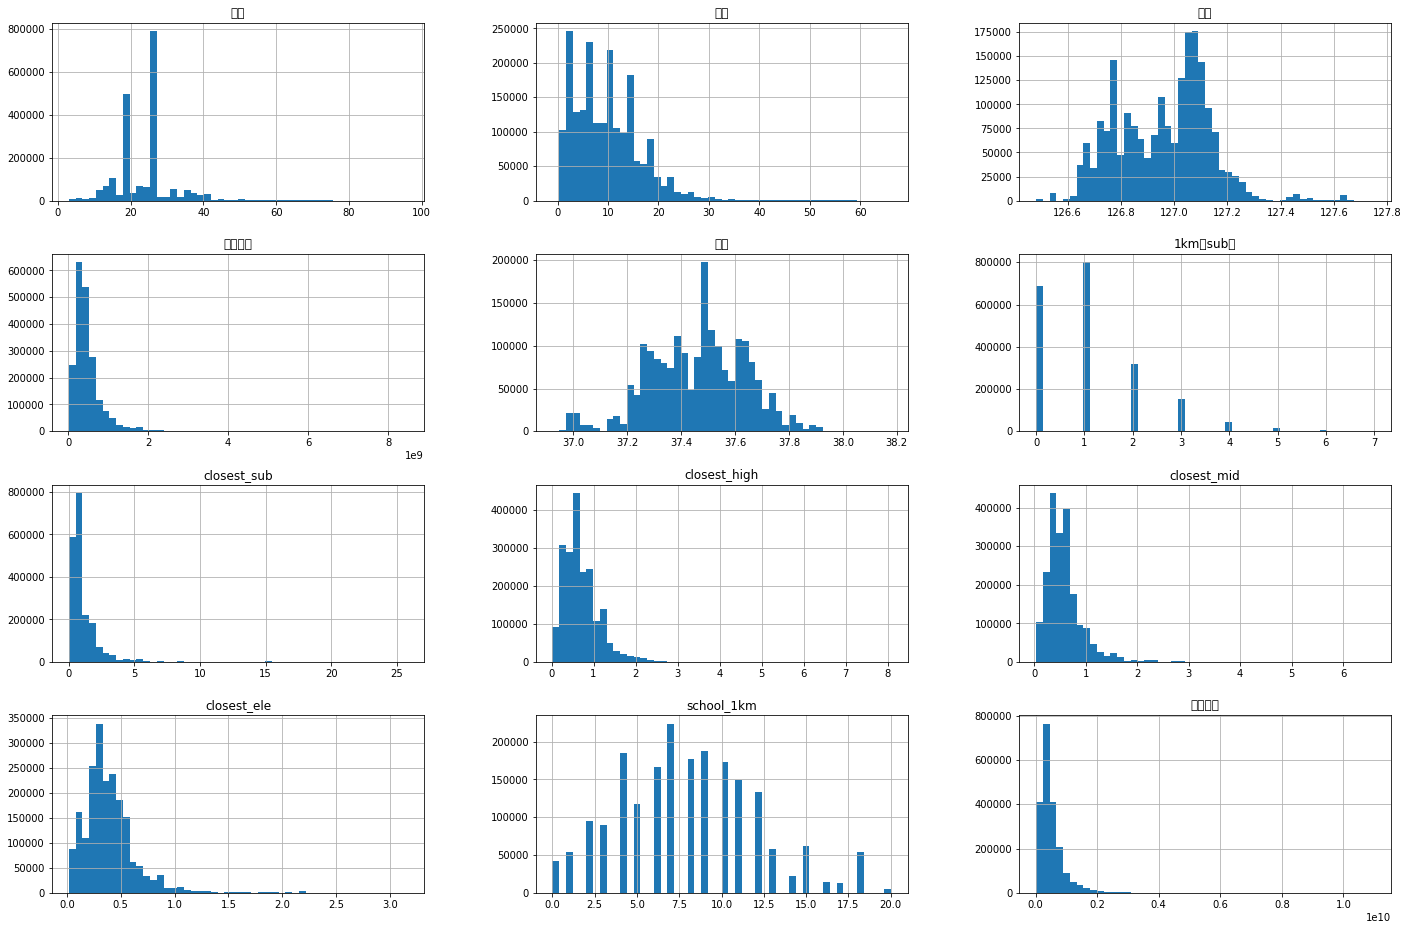

In [104]:
train_data.hist(bins=50, figsize=(24,16))

/home/subin/.local/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.draw()
/home/subin/.local/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.draw()
/home/subin/.local/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 52789 (\N{HANGUL SYLLABLE CEUNG}) missing from current font.
  fig.canvas.draw()
/home/subin/.local/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.draw()
/home/subin/.local/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.draw()
/home/subin/.local/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.draw

<Axes: >

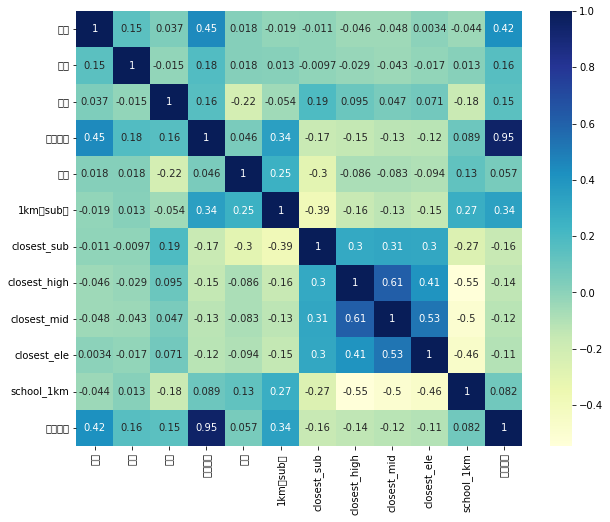

In [105]:
plt.figure(figsize=(10,8))
sns.heatmap(train_data.corr(), annot=True, cmap='YlGnBu')

In [106]:
train_data['층수+'] = train_data['층수']+2
train_data['1km내sub수+'] = train_data['1km내sub수']+2
train_data['school_1km+'] = train_data['school_1km']+2
train_data.drop(['층수', '1km내sub수', 'school_1km'], axis=1, inplace=True)

In [107]:
from scipy.stats import boxcox
train_data[['1km내sub수+', '평수']] = train_data[['1km내sub수+', '평수']].apply(lambda x: boxcox(x)[0])
train_data[['school_1km+']] = np.sqrt(train_data[['school_1km+']])
train_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']] = np.log(train_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']])

/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPyth

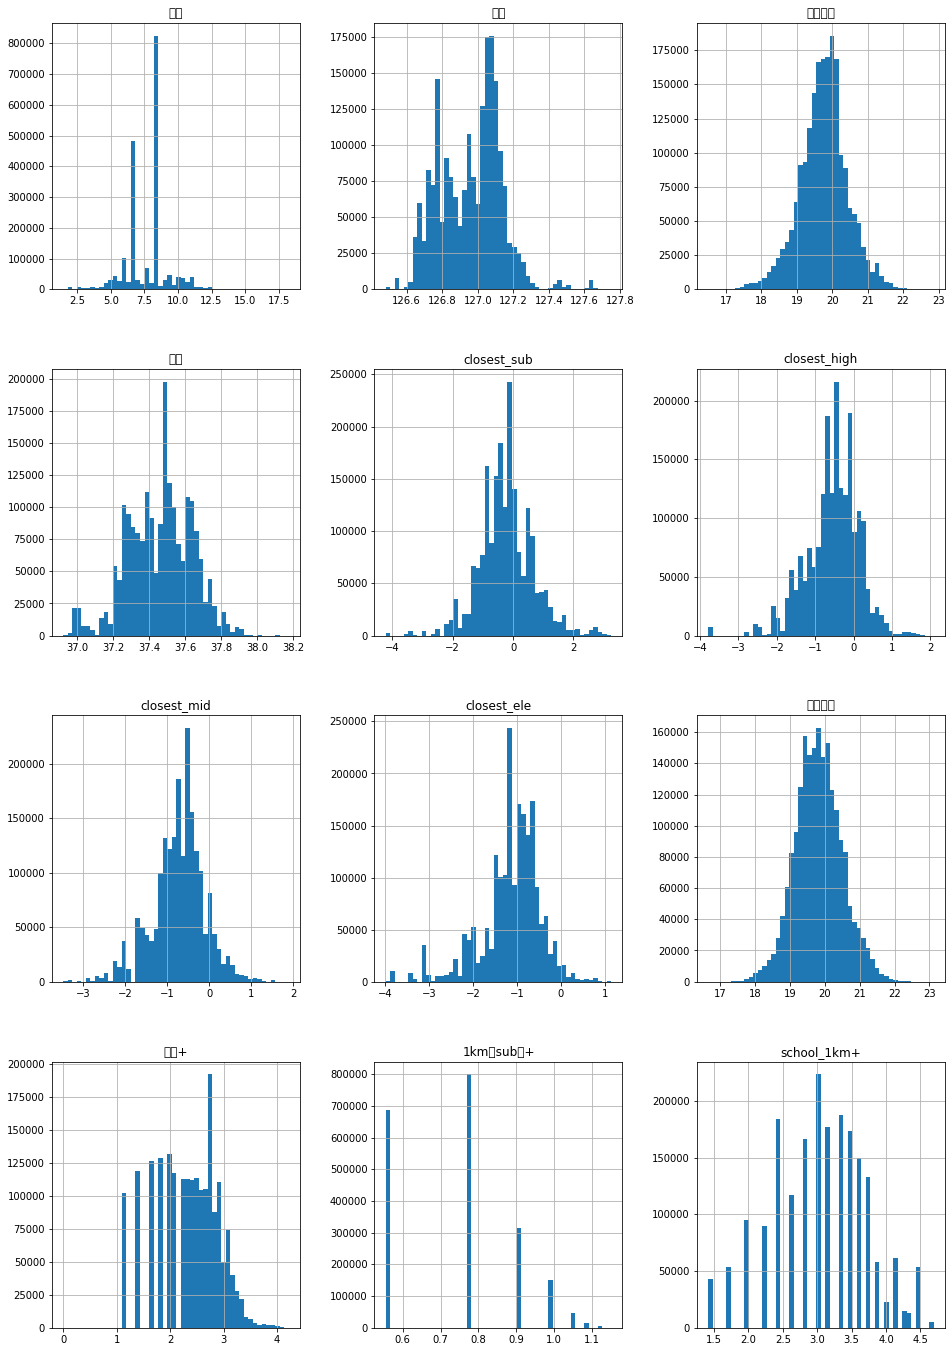

In [108]:
train_data.hist(bins=50, figsize=(16, 24))
plt.rc('font', family='NanumGothic')

In [109]:
x_train, y_train = train_data.drop(['거래가격'], axis=1), train_data['거래가격']

In [110]:
valid_data = x_valid.join(y_valid)

valid_data['층수+'] = valid_data['층수']+2
valid_data['1km내sub수+'] = valid_data['1km내sub수']+2
valid_data['school_1km+'] = valid_data['school_1km']+2
valid_data.drop(['층수', '1km내sub수', 'school_1km'], axis=1, inplace=True)

from scipy.stats import boxcox
valid_data[['1km내sub수+', '평수']] = valid_data[['1km내sub수+', '평수']].apply(lambda x: boxcox(x)[0])
valid_data[['school_1km+']] = np.sqrt(valid_data[['school_1km+']])
valid_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']] = np.log(valid_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']])

x_valid, y_valid = valid_data.drop(['거래가격'], axis=1), valid_data['거래가격']

In [111]:
test_data = X_test.join(y_test)

test_data['층수+'] = test_data['층수']+2
test_data['1km내sub수+'] = test_data['1km내sub수']+2
test_data['school_1km+'] = test_data['school_1km']+2
test_data.drop(['층수', '1km내sub수', 'school_1km'], axis=1, inplace=True)

from scipy.stats import boxcox
test_data[['1km내sub수+', '평수']] = test_data[['1km내sub수+', '평수']].apply(lambda x: boxcox(x)[0])
test_data[['school_1km+']] = np.sqrt(test_data[['school_1km+']])
test_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']] = np.log(test_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']])

X_test, y_test = test_data.drop(['거래가격'], axis=1), test_data['거래가격']

In [112]:
scaler = MinMaxScaler()

scaler.fit(x_train)
x_train_s = scaler.transform(x_train)
x_valid_s = scaler.transform(x_valid)
X_test_s = scaler.transform(X_test)

In [113]:
# 선형회귀모델
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(x_train_s, y_train)

linear.score(X_test_s, y_test)

0.8874241648308441

In [114]:
y_pred_li = linear.predict(x_train_s)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

lin_R2 = r2_score(y_train, y_pred_li)
lin_mae = mean_absolute_error(y_train, y_pred_li)
print(lin_R2)
print(lin_mae)
print('--------------------')
y_pred_li = linear.predict(x_valid_s)
lin_r2 = r2_score(y_valid, y_pred_li)
lin_mae = mean_absolute_error(y_valid, y_pred_li)
print(lin_R2)
print(lin_mae)

0.8876969785332343
0.1863151551205467
--------------------
0.8876969785332343
0.18652550812098945


In [115]:
# 의사결정나무

from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(x_train_s, y_train)

DecisionTreeRegressor()

In [116]:
tree.score(X_test_s, y_test)

0.9048288587636187

In [117]:
y_pred_tr = tree.predict(x_train_s)

tree_R2 = r2_score(y_train, y_pred_tr)
tree_mae = mean_absolute_error(y_train, y_pred_tr)
print(tree_R2)
print(tree_mae)

0.9341958175956339
0.12829761204974524


In [118]:
y_pred_tr = tree.predict(x_valid_s)

tree_R2 = r2_score(y_valid, y_pred_tr)
tree_mae = mean_absolute_error(y_valid, y_pred_tr)
print(tree_R2)
print(tree_mae)

0.9042024923722247
0.15907498225084918


In [119]:
# XGBoost 회귀

import xgboost

xgb_model = xgboost.XGBRegressor()
xgb_model.fit(x_train_s, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [120]:
y_pred_xgb = xgb_model.predict(x_train_s)

xgb_R2 = r2_score(y_train, y_pred_xgb)
xgb_mae = mean_absolute_error(y_train, y_pred_xgb)
print(xgb_R2)
print(xgb_mae)

0.9082496956222448
0.16402181276387998


In [121]:
y_pred_xgb = xgb_model.predict(x_valid_s)

xgb_R2 = r2_score(y_valid, y_pred_xgb)
xgb_mae = mean_absolute_error(y_valid, y_pred_xgb)
print(xgb_R2)
print(xgb_mae)

0.9077096468721774
0.16464058963241743


In [122]:
# k-fold 교차검증 선형회귀모델

def display_scores(model, scores):
    print('<<', model, '모델 평가 결과 >>')
    print('평균 RMSE: ', scores.mean())
    print('표준편차: ', scores.std())

from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(linear, x_valid_s, y_valid, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores('선형회귀', lin_rmse_scores)

<< 선형회귀 모델 평가 결과 >>
평균 RMSE:  0.22601144807637835
표준편차:  0.0003934569481403843


In [123]:
# k-fold 교차검증 의사결정나무
tree_scores = cross_val_score(tree, x_valid_s, y_valid, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores('의사결정나무', tree_rmse_scores)

<< 의사결정나무 모델 평가 결과 >>
평균 RMSE:  0.2402817117490364
표준편차:  0.0006911819360272085


In [124]:
# 최종모델의 성능평가 선형회귀모델

#x_test_nor = scaler.transform(X_test)
final_pred_li = linear.predict(X_test_s)

from sklearn.metrics import mean_squared_error
final_mse_li = mean_squared_error(y_test, final_pred_li)
final_rmse_li = np.sqrt(final_mse_li)
final_r2_li = r2_score(y_test, final_pred_li)

print('RMSE: ', final_rmse_li)
print('R2: ', final_r2_li)

RMSE:  0.22620552506505262
R2:  0.8874241648308441


In [125]:
# 최종모델의 성능평가 의사결정나무

#x_test_nor = scaler.transform(X_test)
final_pred_tree = tree.predict(X_test_s)

from sklearn.metrics import mean_squared_error
final_mse_tree = mean_squared_error(y_test, final_pred_tree)
final_rmse_tree = np.sqrt(final_mse_tree)
final_r2_tree = r2_score(y_test, final_pred_tree)

print('RMSE: ', final_rmse_tree)
print('R2: ', final_r2_tree)

RMSE:  0.2079855955776546
R2:  0.9048288587636187


In [126]:
# 예측값과 실제값의 비교 - 시각화

pred_li = pd.DataFrame(final_pred_li, columns=['예측가격'])
actual_li = pd.DataFrame(y_test)
actual_li.reset_index(inplace=True, drop=True)
table_li = pd.concat([pred_li, actual_li], axis=1)

table_li

,예측가격,거래가격
0,19.381019,19.153049
1,18.949122,19.253590
2,18.978227,18.858936
3,20.838170,20.854294
4,20.279748,20.049921
...,...,...
632054,19.679895,19.897729
632055,20.226892,20.125429
632056,19.626748,19.539096
632057,20.246175,20.078909


<Axes: >

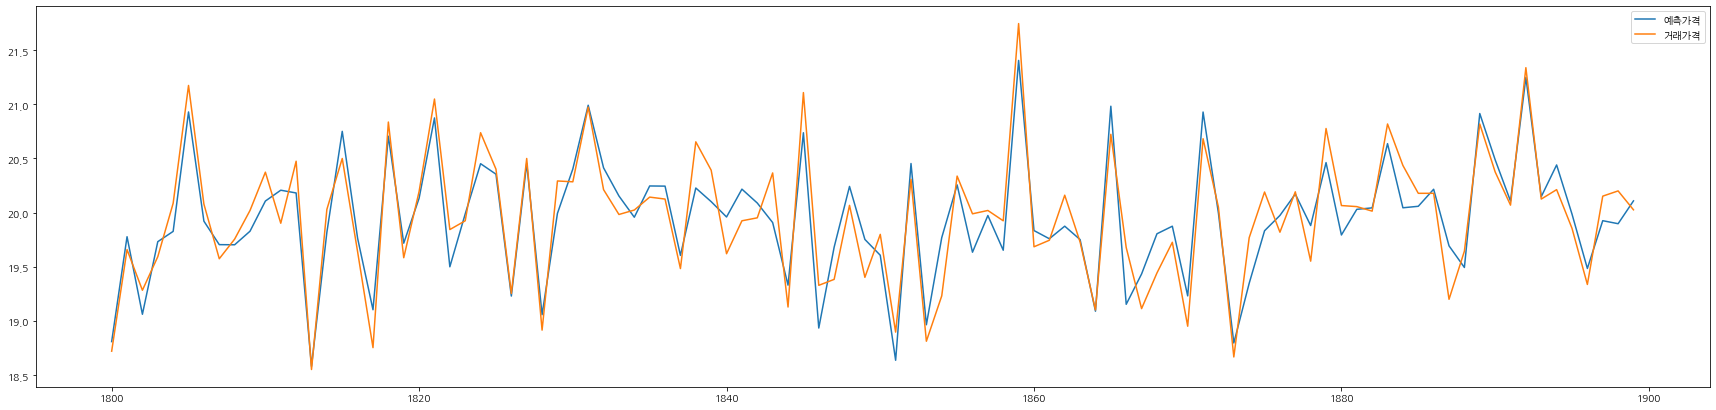

In [127]:
# 선형회귀분석 예측 정확도 시각화

plt.rc('font', family='NanumGothic')
table_li.iloc[1800:1900, :].plot(figsize=(30,7))

<Axes: >

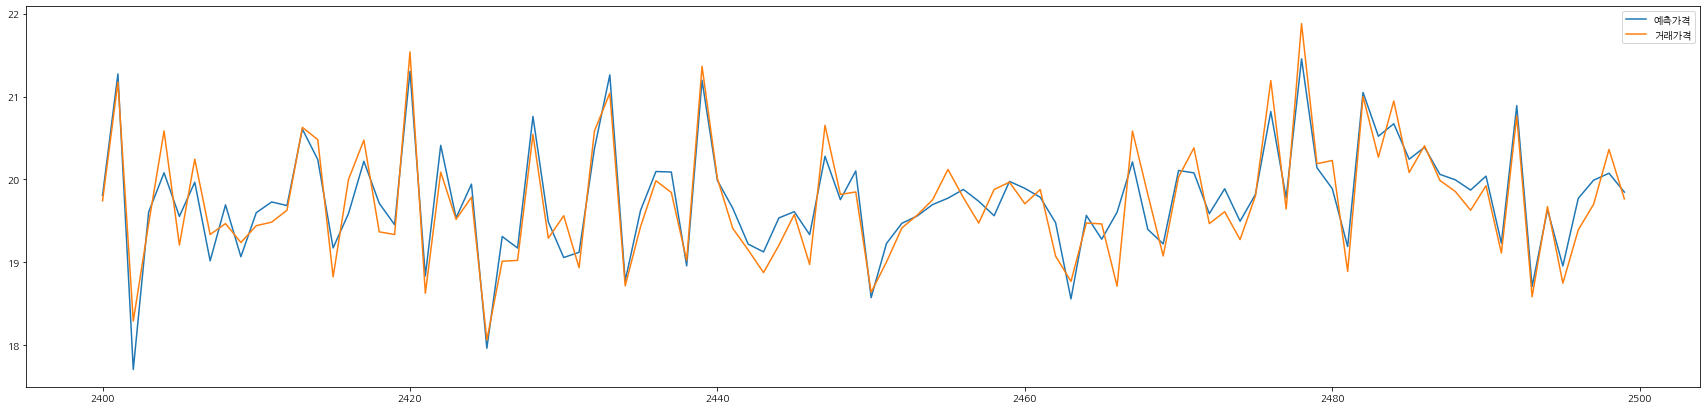

In [128]:
plt.rc('font', family='NanumGothic')
table_li.iloc[2400:2500, :].plot(figsize=(30,7))

<Axes: >

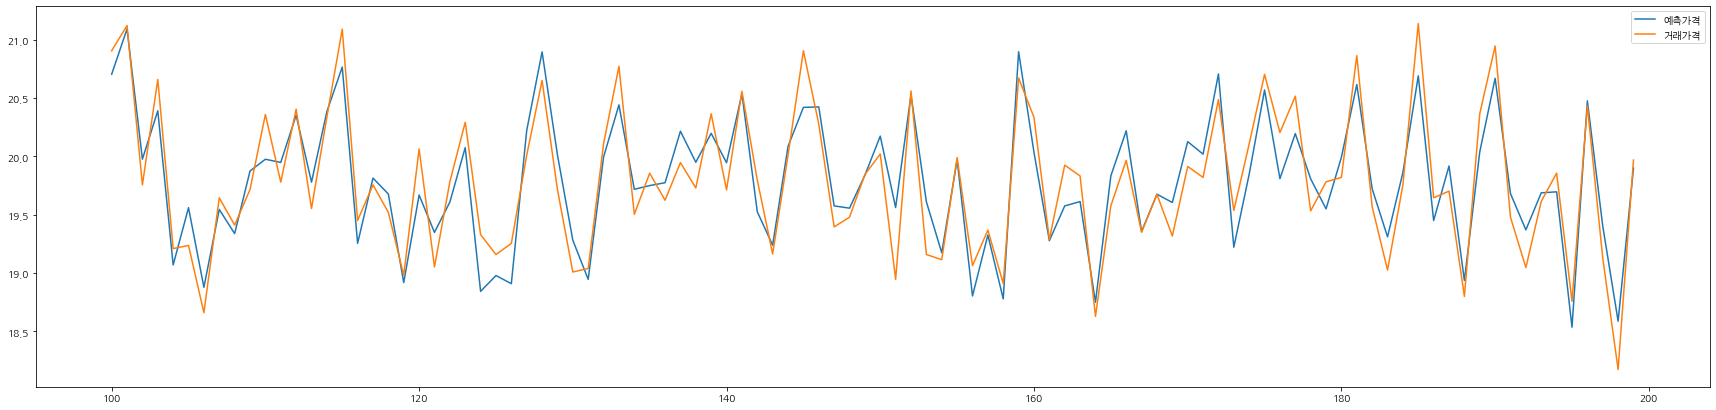

In [129]:
plt.rc('font', family='NanumGothic')
table_li.iloc[100:200, :].plot(figsize=(30,7))

In [130]:
error_li = table_li.copy()
error_li['오차율'] = (error_li['거래가격'] - error_li['예측가격']) / error_li['거래가격'] * 100
error_li['오차율'].describe()

count    632059.000000
mean         -0.011091
std           1.143067
min         -15.139871
25%          -0.848597
50%          -0.152817
75%           0.830408
max           5.491280
Name: 오차율, dtype: float64

In [131]:
# 예측값과 실제값의 비교 - 의사결정나무

pred_tree = pd.DataFrame(final_pred_tree, columns=['예측가격'])
actual_tree = pd.DataFrame(y_test)
actual_tree.reset_index(inplace=True, drop=True)
table_tree = pd.concat([pred_tree, actual_tree], axis=1)

table_tree

,예측가격,거래가격
0,19.224712,19.153049
1,19.198113,19.253590
2,19.156276,18.858936
3,20.812044,20.854294
4,20.049921,20.049921
...,...,...
632054,19.531469,19.897729
632055,20.408555,20.125429
632056,19.539096,19.539096
632057,20.078909,20.078909


<Axes: >

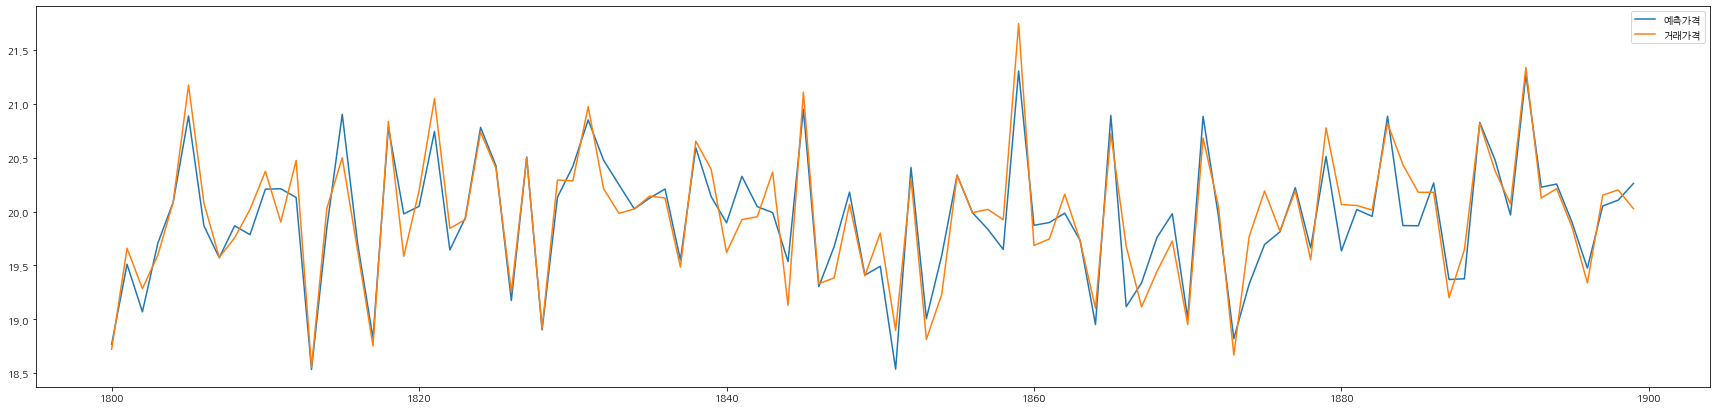

In [132]:
# 의사결정나무 예측 정확도 시각화

plt.rc('font', family='NanumGothic')
table_tree.iloc[1800:1900, :].plot(figsize=(30,7))

<Axes: >

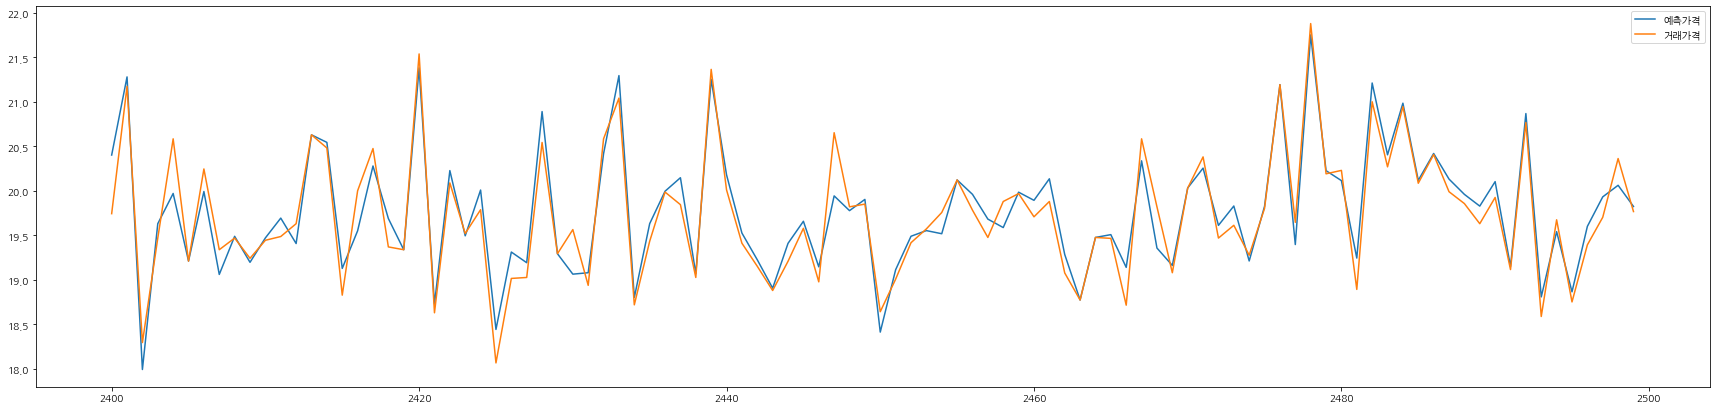

In [133]:
plt.rc('font', family='NanumGothic')
table_tree.iloc[2400:2500, :].plot(figsize=(30,7))

<Axes: >

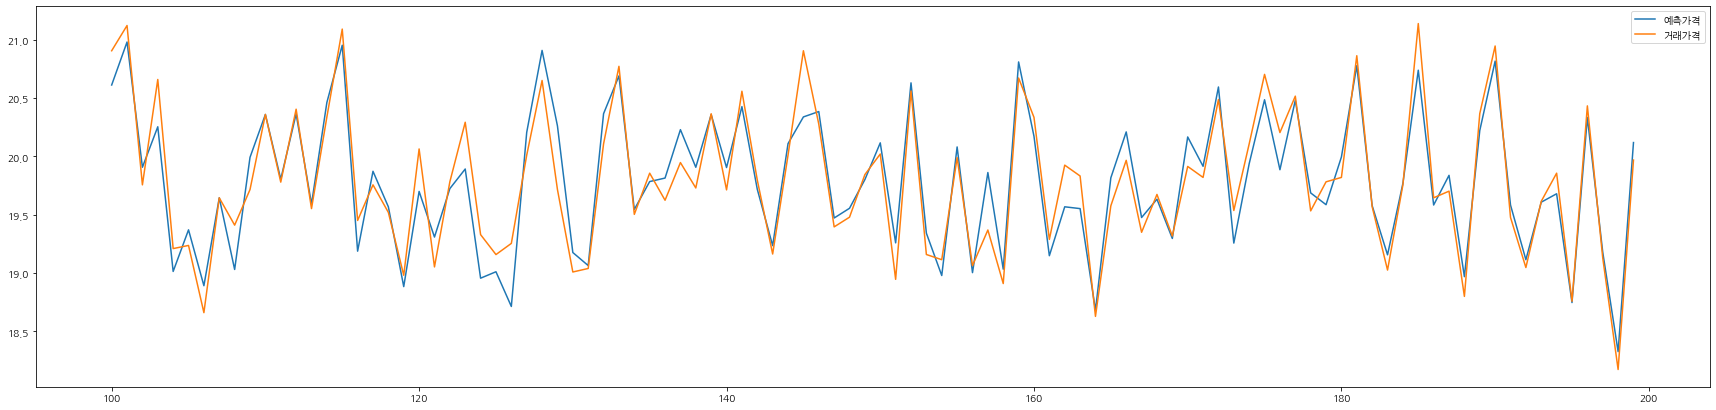

In [134]:
plt.rc('font', family='NanumGothic')
table_tree.iloc[100:200, :].plot(figsize=(30,7))

In [135]:
error_tree = table_tree.copy()
error_tree['오차율'] = (error_tree['거래가격'] - error_tree['예측가격']) / error_tree['거래가격'] * 100
error_tree['오차율'].describe()

count    632059.000000
mean         -0.006901
std           1.045356
min         -12.189718
25%          -0.684630
50%          -0.091942
75%           0.553692
max           6.289900
Name: 오차율, dtype: float64

In [136]:
# 실거래가에 있는데 건물코드와 맵핑했더니 공시지가의 데이터 수가 약 4백만개 -> 2백만개 줄어듦

## 왜 나는 정확한 값이 안 나오지?? 왜 MAE랑 RMSE가 저렇게 작게 나오는 것이며, 다른 데에서는 다 달러 기준으로 나오는데 난 왜 20으로 단위가 줄어서 나오는 거지???

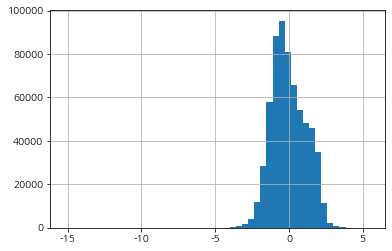

In [140]:
error_li['오차율'].hist(bins=50)
plt.rc("axes", unicode_minus = False)

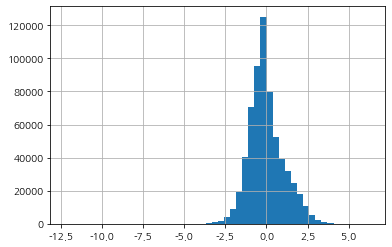

In [139]:
error_tree['오차율'].hist(bins=50)
plt.rc("axes", unicode_minus = False)